# RECOGNITION OF FACIAL EMOTIONS VIA CNN

## PHASE 1: ENVIRONMENT SETUP

In [1]:
# importing and printing the tensorflow version

import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

2025-09-09 09:44:49.094142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757411089.265793      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757411089.316366      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version:  2.18.0


In [2]:
# listing out the number of GPUs available

print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

Number of GPUs available:  1


In [3]:
# listing out names of each GPU

gpus = tf.config.list_physical_devices('GPU')
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu.name}")

GPU 0: /physical_device:GPU:0


In [4]:
# enabling memory growth for GPU

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print(e)

Memory growth enabled


## PHASE 2: CODE AND DATA SETUP

In [5]:
# major imports for the code

import os
import random
from io import StringIO

import numpy as np
import pandas as pd
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

In [6]:
# defining random states

np.random.seed(42) # controls random operations in NumPy
tf.random.set_seed(42) # ensures layers initialize with the same weights each run, critical for identical training paths.
random.seed(42) # controls python’s random module, used in some keras utilities or custom data preprocessing

In [7]:
# assigning variables to the directory of train and test data

train_data = '/kaggle/input/facial-expression-dataset/train/train/'
test_data = '/kaggle/input/facial-expression-dataset/test/test/'

In [8]:
# defining a function to extract the pathname (image situated) and the label of images

def dataset_dir(directory):
    image_situated = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            image_count = 0
            for filename in os.listdir(label_path):
                if filename.lower().endswith('.jpg') or filename.lower().endswith('.png'):
                    image_situated.append(os.path.join(label_path, filename))
                    labels.append(label)
                    image_count += 1
            print(f"Completed reading {image_count} images of {label}")
    print(f"\nTotal number of images found = {len(image_situated)}.")
    return image_situated, labels

In [9]:
# validating the paths and their corresponding labels for training data

print("FOR TRAINING DATA\n")
train_images, train_labels = dataset_dir(train_data)

FOR TRAINING DATA

Completed reading 3171 images of surprise
Completed reading 4097 images of fear
Completed reading 3995 images of angry
Completed reading 4965 images of neutral
Completed reading 4830 images of sad
Completed reading 436 images of disgust
Completed reading 7215 images of happy

Total number of images found = 28709.


In [10]:
# validating the paths and their corresponding labels for testing data

print("FOR TESTING DATA\n")
test_images, test_labels = dataset_dir(test_data)

FOR TESTING DATA

Completed reading 831 images of surprise
Completed reading 1024 images of fear
Completed reading 958 images of angry
Completed reading 1233 images of neutral
Completed reading 1247 images of sad
Completed reading 111 images of disgust
Completed reading 1774 images of happy

Total number of images found = 7178.


In [11]:
# creating train and test dataframes with respective image location and label columns

train = pd.DataFrame({'image_location': train_images, 'label': train_labels})
test = pd.DataFrame({'image_location': test_images, 'label': test_labels})

In [12]:
# shuffling the train dataframe's data to remove bias

train = train.sample(frac = 1, random_state = 42).reset_index(drop = True)

In [13]:
# train dataframe first few samples

print("\nTrain DataFrame:\n")
train.head()


Train DataFrame:



,image_location,label
0,/kaggle/input/facial-expression-dataset/train/...,fear
1,/kaggle/input/facial-expression-dataset/train/...,neutral
2,/kaggle/input/facial-expression-dataset/train/...,happy
3,/kaggle/input/facial-expression-dataset/train/...,fear
4,/kaggle/input/facial-expression-dataset/train/...,happy


In [14]:
# test dataframe first few samples

print("\nTest DataFrame\n")
test.head()


Test DataFrame



,image_location,label
0,/kaggle/input/facial-expression-dataset/test/t...,surprise
1,/kaggle/input/facial-expression-dataset/test/t...,surprise
2,/kaggle/input/facial-expression-dataset/test/t...,surprise
3,/kaggle/input/facial-expression-dataset/test/t...,surprise
4,/kaggle/input/facial-expression-dataset/test/t...,surprise


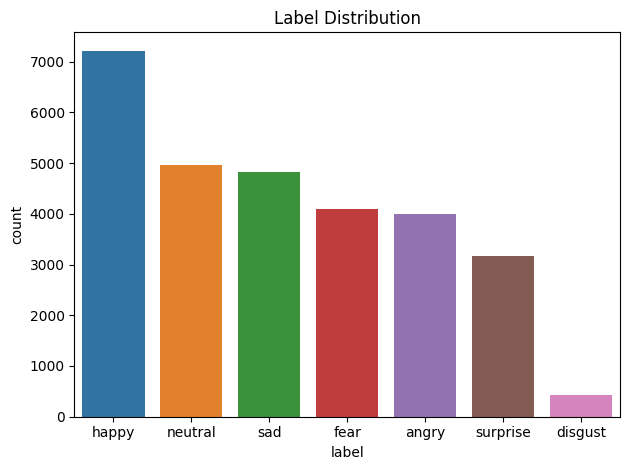

In [15]:
# visualizing the label distribution of training images

sns.countplot(data = train, x ='label', order = train['label'].value_counts().index)
plt.title('Label Distribution')
plt.tight_layout()
plt.show()

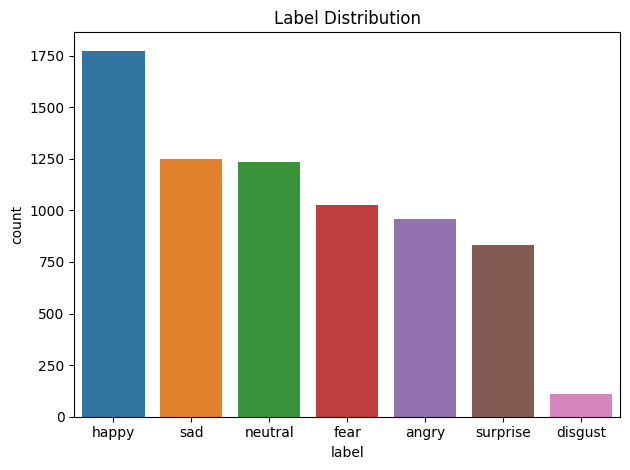

In [16]:
# visualizing the label distribution of testing images

sns.countplot(data = test, x ='label', order = test['label'].value_counts().index)
plt.title('Label Distribution')
plt.tight_layout()
plt.show()

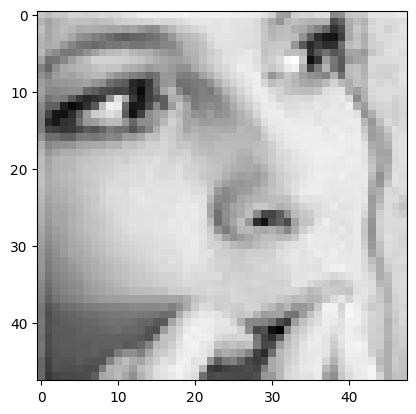

In [17]:
# extraction of first image in train dataset

img_test = Image.open(train['image_location'][0])
plt.imshow(img_test, cmap = 'gray');
plt.show()

In [18]:
# fixing the prominent parameters: image size

img_size = (48, 48)

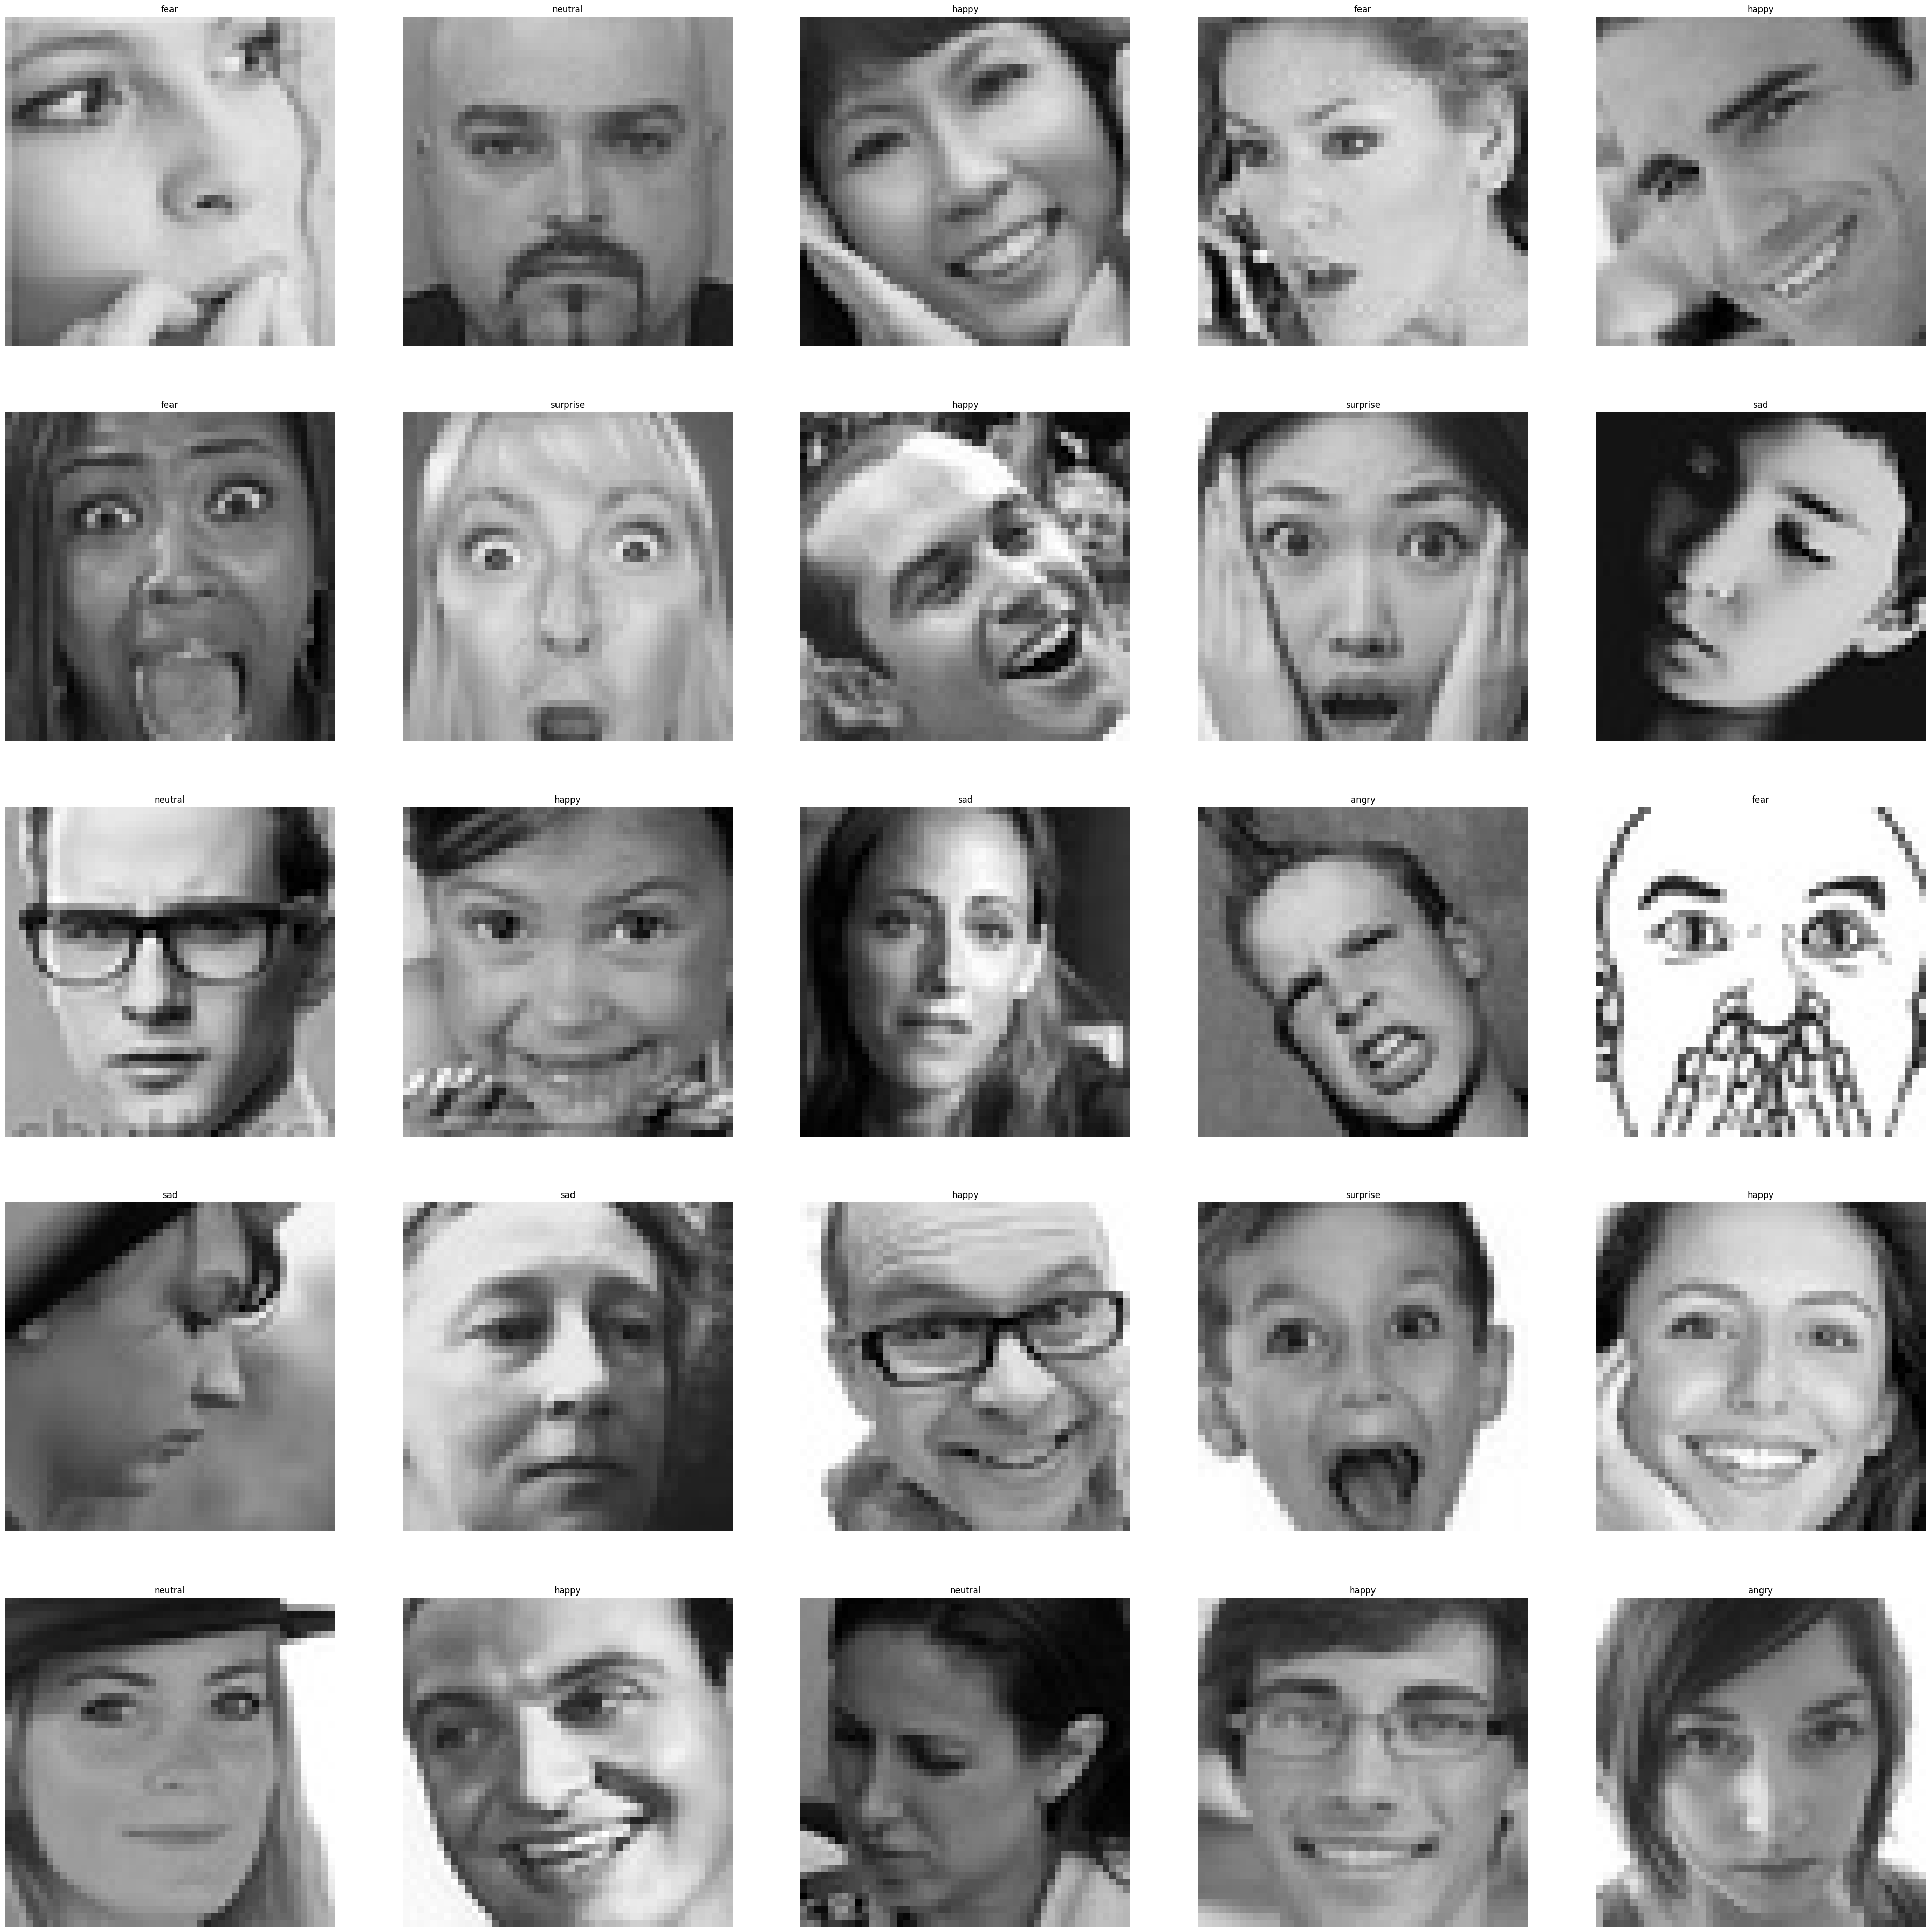

In [19]:
# displaying random sample images (about 25 of them) of training dataset

plt.figure(figsize = img_size)
files = train.iloc[0: 25]
for index, file, label in files.itertuples():
        plt.subplot(5, 5, index + 1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

## PHASE 3: PREPROCESSING & TRAINING IMAGE DATA

In [20]:
# defining a function to preprocess the images

def preprocess_images(images, img_size = img_size):
    features = []
    for image_path in tqdm(images, desc="Processing images"):
        try:
            img = load_img(image_path, color_mode = 'grayscale', target_size = img_size)
            features.append(np.array(img))
        except (Exception, OSError, PIL.UnidentifiedImageError) as e:
            print(f"Error loading image: {image_path}, {e}")
    features = np.array(features).reshape(-1, img_size[0], img_size[1], 1)
    return features / 255.0

In [21]:
# preprocessing training and testing images

with tf.device('/GPU:0'):
    x_train = preprocess_images(train['image_location'])
    x_test = preprocess_images(test['image_location'])

I0000 00:00:1757411105.995007      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Processing images:   0%|          | 0/28709 [00:00<?, ?it/s]

Processing images:   0%|          | 0/7178 [00:00<?, ?it/s]

In [22]:
# initiating label encoder

le = LabelEncoder()

In [23]:
# assigning the output class, and image input shape for grayscale imanges their respective variables

output_class = 7
input_shape = (48, 48, 1)

In [24]:
# converting the categorical labels in the train['label'] datasets into one-hot encoded format using LabelEncoder (le) and to_categorical

y_train = to_categorical(le.fit_transform(train['label']), num_classes = output_class)

In [25]:
# converting the categorical labels in the test['label'] datasets into one-hot encoded format using LabelEncoder (le) and to_categoricaland 

y_test = to_categorical(le.transform(test['label']), num_classes = output_class)

In [26]:
# prints the shapes of the training and testing datasets (x_train, x_test, y_train, y_test) to verify their dimensions, ensuring they are correctly formatted for model training

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (28709, 48, 48, 1)
x_test shape: (7178, 48, 48, 1)
y_train shape: (28709, 7)
y_test shape: (7178, 7)


In [27]:
# augmenting the images

datagen = ImageDataGenerator(rotation_range = 15,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             shear_range = 0.1,
                             zoom_range = 0.1,
                             horizontal_flip = True,
                             fill_mode = 'nearest'
                            )

## PHASE 4: DEFINING STANDARD OF EVALUATION AND VISUALIZATION FOR A MODEL

In [28]:
# 1. training curves visualization

def plot_training_curves(history, model_name):
    plt.figure(figsize = (12, 5))
    
    # accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(history.history['val_accuracy'], label = 'validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [29]:
# 2. model evaluation

def evaluate_model(model, x_test, y_test, class_names, model_name = "model"):
    # get predictions
    y_pred = model.predict(x_test, verbose = 0)
    y_pred_classes = np.argmax(y_pred, axis = 1)
    y_true_classes = np.argmax(y_test, axis = 1)
    
    # basic metrics (accuracy only)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 0)
    print(f"Test Loss: {test_loss*100:.4f}")
    print(f"Test Accuracy: {test_acc*100:.4f}")
    
    # detailed classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true_classes, y_pred_classes, target_names = class_names))
    
    # confusion matrix heatmap
    plt.figure(figsize = (10, 8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = class_names, yticklabels = class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # inference speed test
    start_time = time.time()
    _ = model.predict(x_test[:100], verbose = 0)
    inference_time = (time.time() - start_time) / 100
    print(f"Average inference time: {inference_time:.4f}s per sample")
    
    # comprehensive metrics
    metrics = {
        'test_loss': test_loss, 
        'test_accuracy': test_acc, 
        'precision': precision_score(y_true_classes, y_pred_classes, average = 'weighted'), 
        'recall': recall_score(y_true_classes, y_pred_classes, average = 'weighted'), 
        'f1_score': f1_score(y_true_classes, y_pred_classes, average = 'weighted'), 
        'inference_time': inference_time
    }
    
    print(f"\nWEIGHTED METRICS:")
    print(f"precision: {metrics['precision']:.4f}")
    print(f"recall: {metrics['recall']:.4f}")
    print(f"f1-score: {metrics['f1_score']:.4f}")
    
    return metrics

In [30]:
# 3. error analysis gallery

def plot_misclassified_samples(model, x_test, y_test, class_names, num_samples = 16):
    # get predictions
    y_pred = model.predict(x_test, verbose = 0)
    y_pred_classes = np.argmax(y_pred, axis = 1)
    y_true_classes = np.argmax(y_test, axis = 1)
    
    # find misclassified samples
    errors = np.where(y_pred_classes != y_true_classes)[0]
    if len(errors) == 0:
        print("No misclassifications found!")
        return
    
    print(f"\nFound {len(errors)} misclassified samples")
    
    # randomly sample errors
    sample_errors = np.random.choice(errors, min(num_samples, len(errors)), replace = False)
    
    # plot grid
    n_cols = 4
    n_rows = int(np.ceil(len(sample_errors) / n_cols))
    plt.figure(figsize = (12, 3*n_rows))
    
    for i, idx in enumerate(sample_errors):
        plt.subplot(n_rows, n_cols, i+1)
        
        # display image (handle both grayscale and rgb)
        img = x_test[idx]
        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap = 'gray')
        else:
            plt.imshow(img)
        
        # add labels and confidence
        confidence = np.max(y_pred[idx])
        true_label = class_names[y_true_classes[idx]]
        pred_label = class_names[y_pred_classes[idx]]
        
        plt.title(f'true: {true_label}\npred: {pred_label}\nconf: {confidence:.2f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [31]:
# 4. prediction visualization

def visualize_predictions(model, x_test, y_test, class_names, num_samples = 6):
    plt.figure(figsize = (15, 2.5*num_samples))
    
    for i in range(num_samples):
        # random sample
        idx = random.randint(0, len(x_test)-1)
        img = x_test[idx]
        
        # get prediction
        pred = model.predict(np.expand_dims(img, axis = 0), verbose = 0)
        pred_probs = pred[0]
        pred_class = np.argmax(pred_probs)
        true_class = np.argmax(y_test[idx])
        
        # plot image
        plt.subplot(num_samples, 2, 2*i+1)
        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap = 'gray')
        else:
            plt.imshow(img)
        plt.title(f'\ntrue: {class_names[true_class]}')
        plt.axis('off')
        
        # plot prediction probabilities
        plt.subplot(num_samples, 2, 2*i+2)
        bars = plt.barh(range(len(class_names)), pred_probs)
        plt.yticks(range(len(class_names)), class_names)
        plt.xlabel('Confidence')
        plt.title(f'\npredicted: {class_names[pred_class]} ({pred_probs[pred_class]:.3f})')
        
        # highlight predicted class in red, true class in green
        bars[pred_class].set_color('red')
        bars[true_class].set_color('green')
    
    plt.tight_layout()
    plt.show()

In [32]:
# 5. robustness testing

def test_robustness(model, x_test, y_test, num_samples = 3):
    print("Robustness Testing: \n")
    
    # noise sensitivity
    noise_levels = [0.05, 0.1, 0.2]
    print("\nNoise Sensitivity:")
    for noise in noise_levels:
        noisy_data = x_test + np.random.normal(0, noise, x_test.shape)
        noisy_data = np.clip(noisy_data, 0, 1)
        _, acc = model.evaluate(noisy_data, y_test, verbose = 0)
        print(f"\nNoise level {noise}: Accuracy = {acc:.3f}")
    
    # visual comparison
    plt.figure(figsize = (12, 4*num_samples))
    for i in range(num_samples):
        idx = random.randint(0, len(x_test)-1)
        original = x_test[idx]
        
        # original image
        plt.subplot(num_samples, 3, i*3+1)
        if original.shape[-1] == 1:
            plt.imshow(original.squeeze(), cmap = 'gray')
        else:
            plt.imshow(original)
        plt.title('Original')
        plt.axis('off')
        
        # noisy image
        plt.subplot(num_samples, 3, i*3+2)
        noisy = original + np.random.normal(0, 0.1, original.shape)
        noisy = np.clip(noisy, 0, 1)
        if noisy.shape[-1] == 1:
            plt.imshow(noisy.squeeze(), cmap = 'gray')
        else:
            plt.imshow(noisy)
        plt.title('With Noise (0.1)')
        plt.axis('off')
        
        # occluded image
        plt.subplot(num_samples, 3, i*3+3)
        occluded = original.copy()
        h, w = original.shape[:2]
        size = 16
        i_start = random.randint(0, h-size)
        j_start = random.randint(0, w-size)
        occluded[i_start:i_start+size, j_start:j_start+size] = 0
        if occluded.shape[-1] == 1:
            plt.imshow(occluded.squeeze(), cmap = 'gray')
        else:
            plt.imshow(occluded)
        plt.title('With Occlusion')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## PHASE 5: WARMING UP THE GPU

In [33]:
# clearing the previous session

tf.keras.backend.clear_session()

In [34]:
# warming up the gpu with a simple model

warmup_model = Sequential()
warmup_model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
warmup_model.add(MaxPooling2D((2, 2)))
warmup_model.add(Flatten())
warmup_model.add(Dense(output_class, activation='softmax'))

warmup_model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# dummy warmup data
X_warmup = np.random.rand(32, *input_shape).astype(np.float32) # batch of 32
y_warmup = tf.keras.utils.to_categorical(np.random.randint(0, output_class, 32), num_classes = output_class)

# run a few steps to warm up gpu
print(" Warming up GPU with dummy data...")
start = time.time()
with tf.device('/GPU:0'):
    warmup_model.fit(X_warmup, y_warmup, epochs = 2, batch_size = 32, verbose = 1)
end = time.time()
print("GPU warmup complete!")

print(f"GPU warmup finished in {end - start:.2f} seconds.")

 Warming up GPU with dummy data...
Epoch 1/2


I0000 00:00:1757411345.488123      99 service.cc:148] XLA service 0x798ac8004ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757411345.488571      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757411345.654918      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1875 - loss: 1.9081
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2812 - loss: 6.0955
GPU warmup complete!
GPU warmup finished in 2.49 seconds.


I0000 00:00:1757411346.850358      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## PHASE 6: MODEL ARCHITECTURE

In [35]:
# clearing the previous session

tf.keras.backend.clear_session()

In [36]:
# defining model architecture

model = Sequential()
model.add(Conv2D(64, kernel_size = (3, 3), padding = "same", input_shape = input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(128, kernel_size = (5, 5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size = (3, 3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (5, 5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.20))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(output_class, activation = 'softmax'))

opt = Adam(learning_rate = 0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [37]:
# callbacks

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 32, restore_best_weights = True, verbose = 1)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 8, min_lr = 1e-6, mode = 'auto', verbose = 1) # mode automatically choose 'min' if we are monitoring val_loss and 'max' if we are monitoring val_accuracy
checkpoint = ModelCheckpoint('model.keras', monitor = 'val_accuracy', save_best_only = True, mode = 'auto', verbose = 1) # mode automatically choose 'min' if we are monitoring val_loss and 'max' if we are monitoring val_accuracy

In [38]:
# training the model

with tf.device('/GPU:0'):
    model_history = model.fit(datagen.flow(x = x_train, y = y_train, batch_size = 32), validation_data = (x_test, y_test), epochs = 128, callbacks = [early_stopping, lr_scheduler, checkpoint], verbose = 1)

Epoch 1/128
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2194 - loss: 1.9375
Epoch 1: val_accuracy improved from -inf to 0.24923, saving model to model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.2194 - loss: 1.9374 - val_accuracy: 0.2492 - val_loss: 1.7972 - learning_rate: 0.0010
Epoch 2/128
895/898 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3118 - loss: 1.6936
Epoch 2: val_accuracy improved from 0.24923 to 0.39398, saving model to model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3119 - loss: 1.6934 - val_accuracy: 0.3940 - val_loss: 1.5609 - learning_rate: 0.0010
Epoch 3/128
895/898 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4142 - loss: 1.5185
Epoch 3: val_accuracy improved from 0.39398 to 0.47005, saving model to model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4143 - loss: 1.5183 - val_accuracy: 0.4700 - val_loss: 1.3739 - learning_rate: 0.0010
Epoch 4/128
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - ac

## PHASE 8: RESULT AND CONCLUSION

Evaluating Model Architecture: 



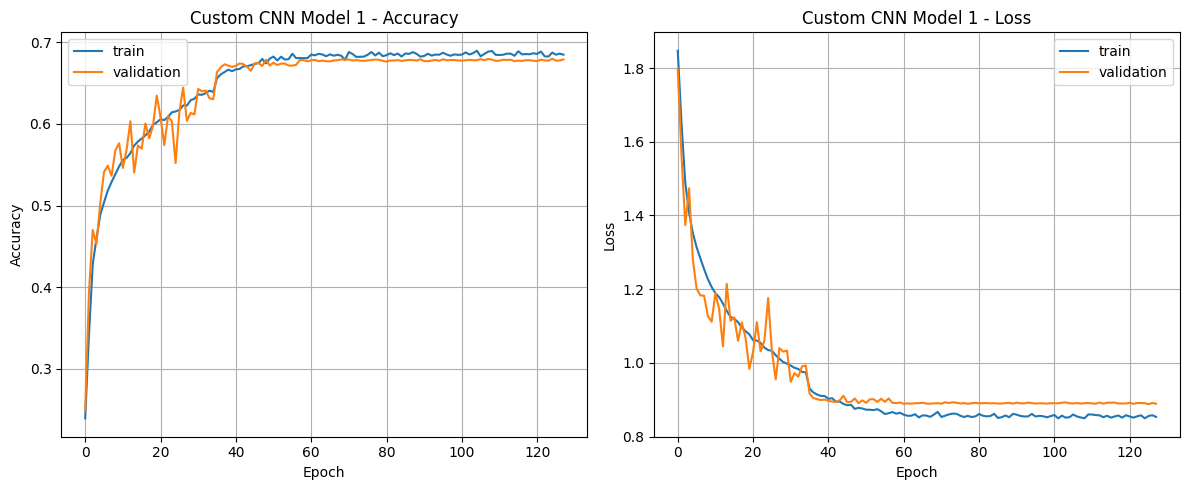

Test Loss: 89.0435
Test Accuracy: 67.9855

Classification Report:

              precision    recall  f1-score   support

       angry       0.59      0.63      0.61       958
     disgust       0.75      0.50      0.60       111
        fear       0.60      0.41      0.49      1024
       happy       0.88      0.88      0.88      1774
     neutral       0.57      0.73      0.64      1233
         sad       0.57      0.52      0.54      1247
    surprise       0.78      0.81      0.80       831

    accuracy                           0.68      7178
   macro avg       0.68      0.64      0.65      7178
weighted avg       0.68      0.68      0.68      7178



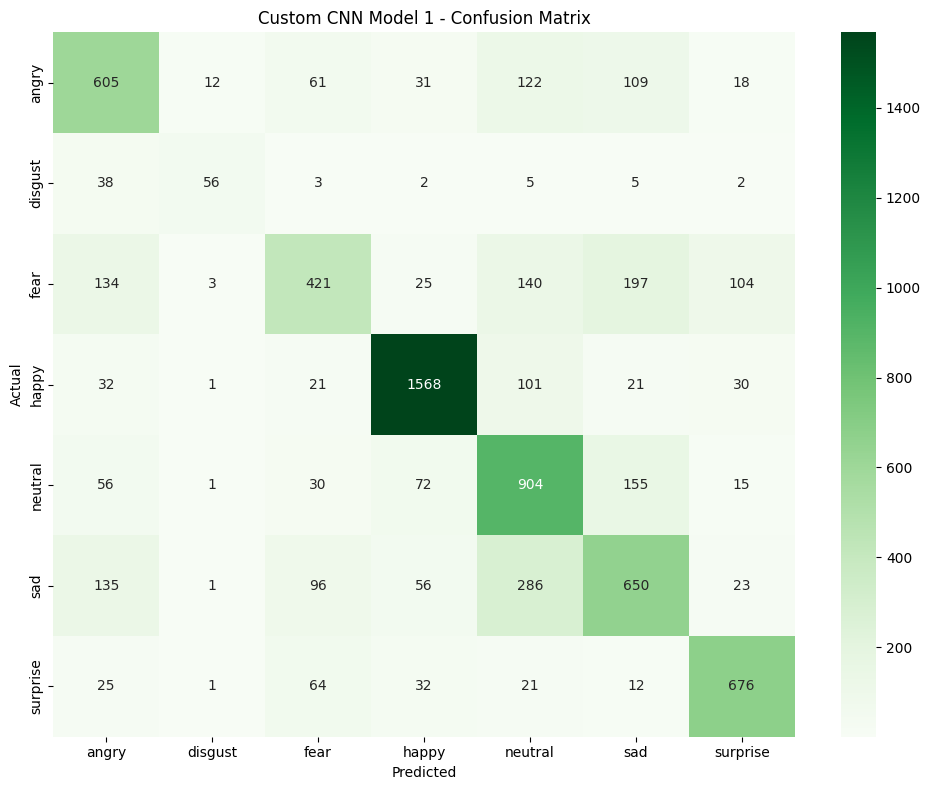

Average inference time: 0.0068s per sample

WEIGHTED METRICS:
precision: 0.6804
recall: 0.6799
f1-score: 0.6751

Found 2298 misclassified samples


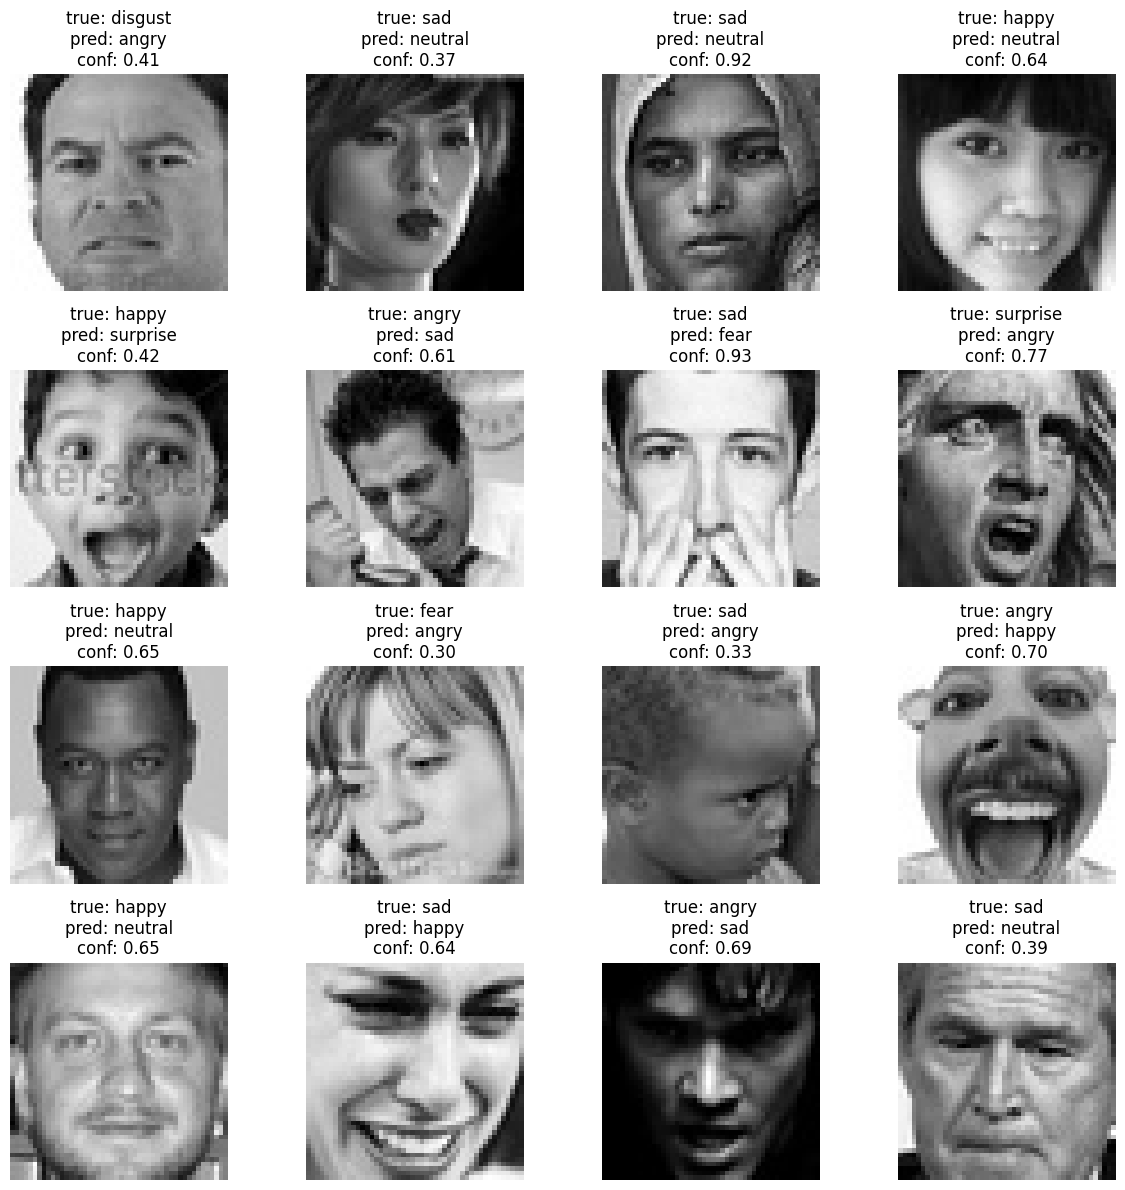

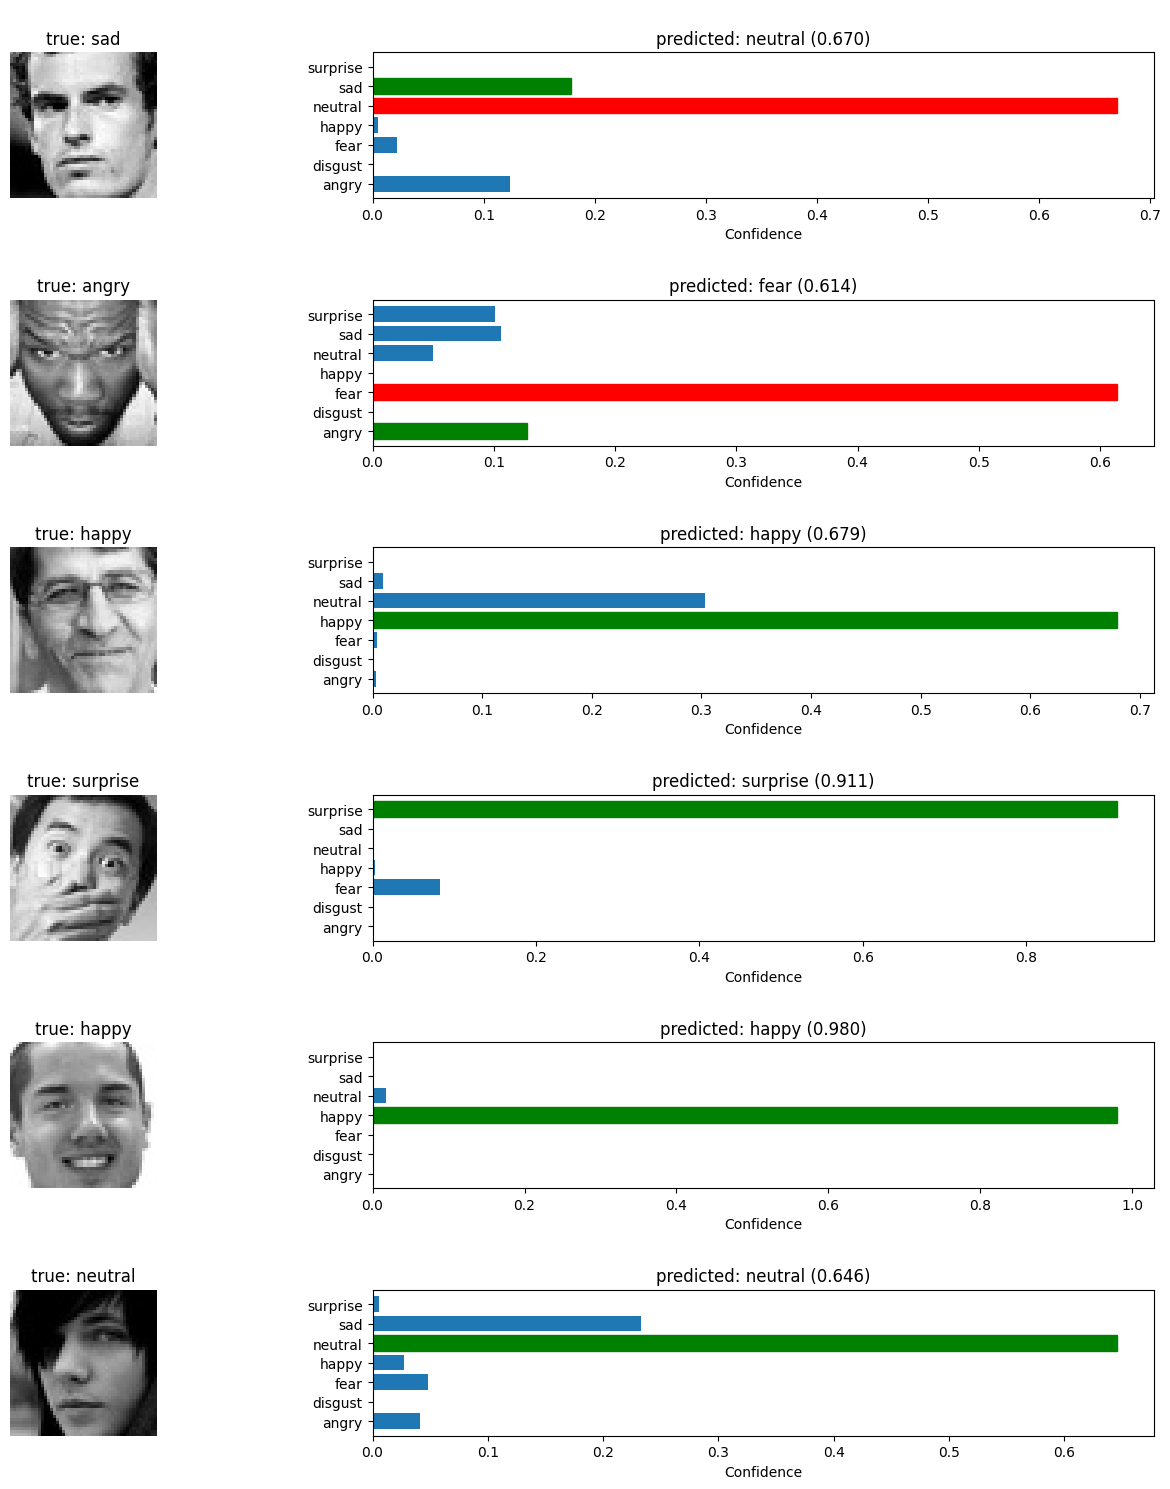

Robustness Testing: 


Noise Sensitivity:

Noise level 0.05: Accuracy = 0.340

Noise level 0.1: Accuracy = 0.176

Noise level 0.2: Accuracy = 0.174


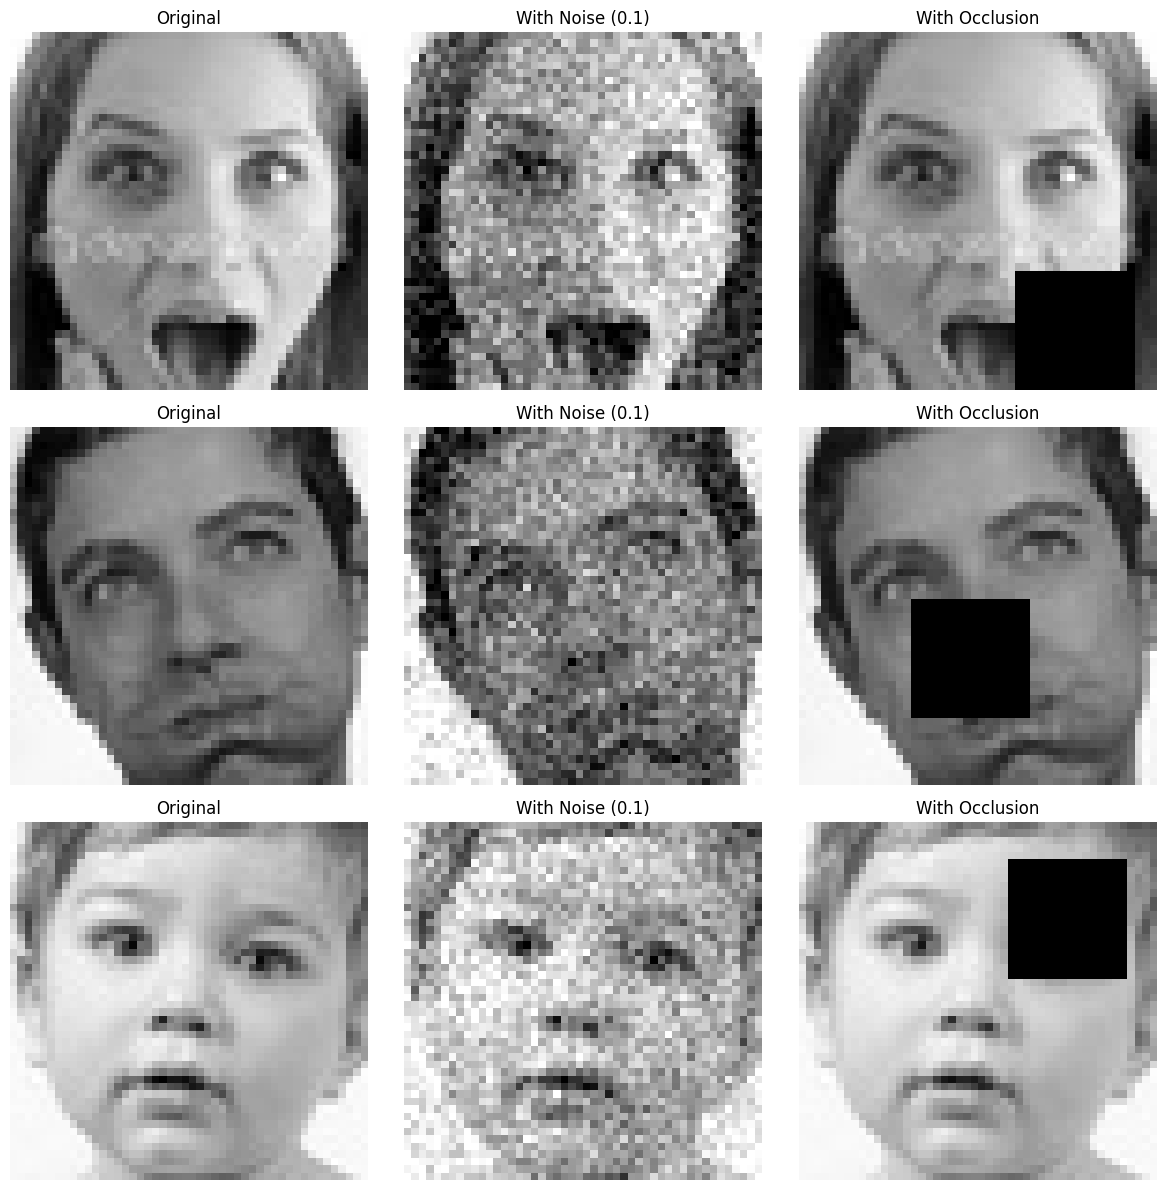

In [39]:
# evaluation and study of error for model

print("Evaluating Model Architecture: \n")

plot_training_curves(model_history, "Custom CNN Model 1")
metrics = evaluate_model(model, x_test, y_test, le.classes_, "Custom CNN Model 1")
plot_misclassified_samples(model, x_test, y_test, le.classes_)
visualize_predictions(model, x_test, y_test, le.classes_)
test_robustness(model, x_test, y_test)

In [40]:
# displaying the model summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 18,947,735 (72.28 MB)

 Trainable params: 6,314,631 (24.09 MB)

 Non-trainable params: 3,840 (15.00 KB)

 Optimizer params: 12,629,264 (48.18 MB)